In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import stumpy
import pandas as pd
from scipy import signal
from sklearn.linear_model import Ridge
from scipy.spatial import distance
from fatf.utils.kernels import exponential_kernel 

import warnings
warnings.filterwarnings('ignore')

import sys

## Update path to where LimeSegment is store on your system

# sys.path.append('/Users/rithikbansal/v2.0/listen_to_your_heart/LIMESegment')
sys.path.append('C:\\Users\\Rushali\\Documents\\Code\\AI project\\listen_to_your_heart\\LIMESegment')

from Utils.explanations import LIMESegment#, NEVES, LEFTIST, NNSegment, RBP, background_perturb
# from  Utils.data import loadUCRDataID
from  Utils.models import *
from  Utils.metrics import *

In [2]:
import os
import numpy as np

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

np.set_printoptions(precision=4)
seg_length = 500

X = None
y = None

db1_pos = ['chfdb']
db1_neg = ['nsrdb', 'fantasia']
db2_pos = ['chf2db']
db2_neg = ['nsr2db']

for db in db1_pos:
    for record in os.listdir(f'data/{db}/rr'):
        rr = np.loadtxt(f'data/{db}/rr/{record}')
        n_segments = rr.shape[0] // seg_length
        rr = rr[:n_segments*seg_length].reshape((n_segments, seg_length))
        labels = np.c_[np.ones(n_segments), np.zeros(n_segments)]

        if X is None or y is None:
            X = rr
            y = labels
        else:
            X = np.r_[rr, X]
            y = np.r_[labels, y]

for db in db1_neg:
    for record in os.listdir(f'data/{db}/rr'):
        rr = np.loadtxt(f'data/{db}/rr/{record}')
        n_segments = rr.shape[0] // seg_length
        rr = rr[:n_segments*seg_length].reshape((n_segments, seg_length))
        labels = np.c_[np.zeros(n_segments), np.ones(n_segments)]

        if X is None or y is None:
            X = rr
            y = labels
        else:
            X = np.r_[rr, X]
            y = np.r_[labels, y]

X.shape, y.shape

X_raw = X.copy()
X = preprocessing.scale(X, axis=1)
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=410)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, random_state=410)
 
 
_, X_test_raw, _, y_test_raw = train_test_split(
    X_raw, y, test_size=0.1, random_state=410)

TensorFlow version: 2.6.0


In [3]:
from tensorflow.keras.models import load_model

lstm_model = load_model("model4.keras", compile=False)

In [4]:
lstm_model.summary()

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

y_pred_lstm = lstm_model.predict(X_test).argmax(axis=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 1)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 500, 10)      280         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 500, 5)       10          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 5)       10          input_1[0][0]                    
______________________________________________________________________________________________

In [5]:
print(recall_score(y_test.argmax(axis=1), y_pred_lstm))
print(precision_score(y_test.argmax(axis=1), y_pred_lstm))
print(accuracy_score(y_test.argmax(axis=1), y_pred_lstm))

0.9836065573770492
0.9813084112149533
0.9797297297297297


In [6]:
cnn_model = load_model("cnn_model.keras", compile=False)

pred_test_cnn = cnn_model.predict(X_test)
pred_test_cnn = np.argmax(pred_test_cnn, axis=1)

print(recall_score(y_test.argmax(axis=1), pred_test_cnn ))
print(precision_score(y_test.argmax(axis=1), pred_test_cnn ))
print(accuracy_score(y_test.argmax(axis=1), pred_test_cnn ))

0.9695550351288056
0.92
0.9337837837837838


Here are the prediction classes: ['healthy heart', 'heart failure risk']
Comparision of CNN model. Actual: heart failure risk, predicted: heart failure risk


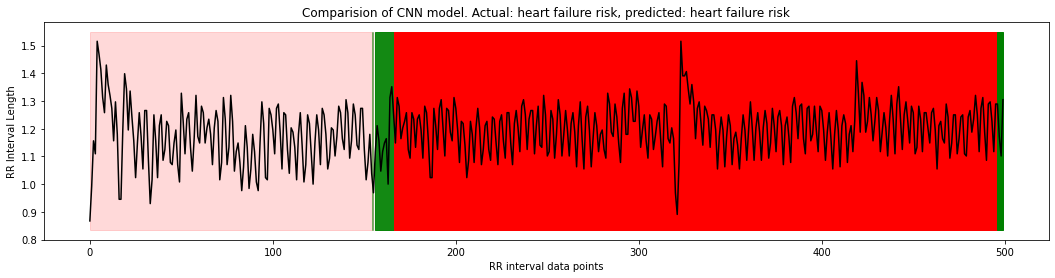

Comparision of LSTM model. Actual: heart failure risk, predicted: heart failure risk


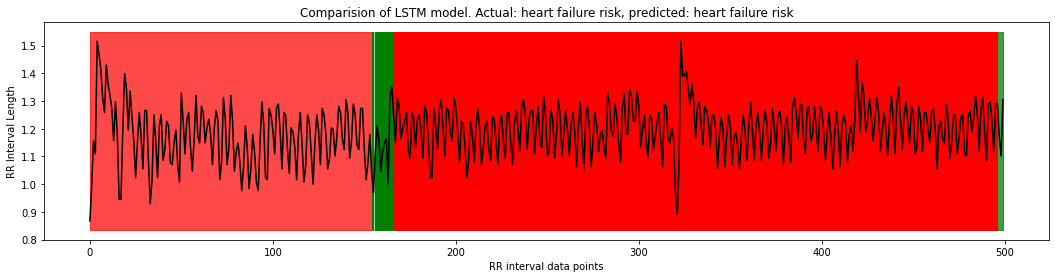

Comparision of CNN model. Actual: healthy heart, predicted: healthy heart


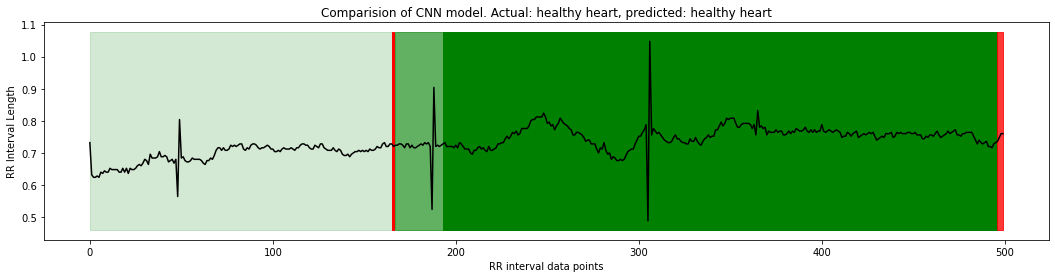

Comparision of LSTM model. Actual: healthy heart, predicted: healthy heart


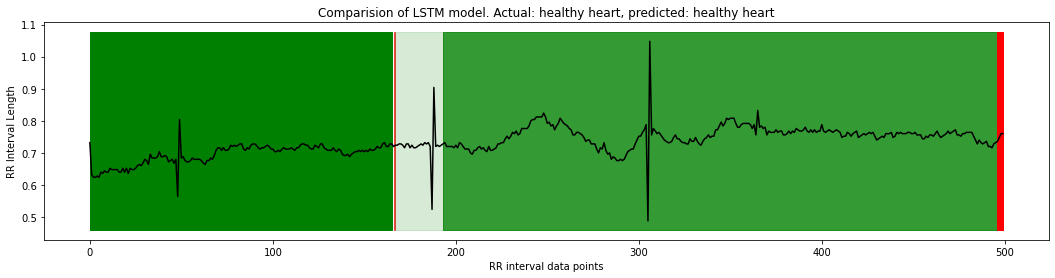

In [10]:
import random
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap


random_test_data_points = {}

# Change this number if you want more test data points respective
# results for cnn and lstm against LIME
number_of_test_plots = 2

for _ in range(number_of_test_plots):
    index = random.randint(0, min(len(y_test_raw),len(X_test)))
    cnn_exp = LIMESegment(X_test[index], cnn_model, 'class', 'dtw', 100, 3, 5)
    lstm_exp = LIMESegment(X_test[index], lstm_model, 'class', 'dtw', 100, 3, 5)

    random_test_data_points[index] = [(y_test_raw[index], pred_test_cnn[index], y_pred_lstm[index]), cnn_exp, lstm_exp]


labels_for_plots = ['healthy heart', 'heart failure risk']
print(f'Here are the prediction classes: {labels_for_plots}')

def generic_generate_plots(actual_prediction, model_prediction, model_name, model_exp, all_data):

    # Determining the color intensity gradient based on the explainability value
    # for each segment. Normalizing the value to between 0 and 1
    # Making sure that for healthy heart its green and for failure its
    # towards red
    color_intensity = model_exp[0][int(model_prediction)]
    segment_indices = model_exp[1]

    normalized_color_intensity = np.zeros_like(color_intensity)

    positive_values = color_intensity[color_intensity > 0]
    negative_values = color_intensity[color_intensity < 0]

    min_positive, max_negative = 0, 0
    max_positive = 0
    min_negative = None

    if len(positive_values) > 0:
        min_positive = np.min(positive_values)
        max_positive = np.max(positive_values)
        scaled_positive = positive_values / max_positive
        normalized_color_intensity[color_intensity > 0] = scaled_positive
    else:
        scaled_positive = np.zeros_like(color_intensity)

    if len(negative_values) > 0:
        max_negative = np.max(negative_values)
        min_negative = np.min(negative_values)
        scaled_negative = negative_values / np.abs(min_negative)
        normalized_color_intensity[color_intensity < 0] = -scaled_negative
    else:
        scaled_negative = np.zeros_like(color_intensity)


    normalized_color_intensity = [(normalized_color_intensity[l] + 0.00001) if color_intensity[l] > 0 and (normalized_color_intensity[l] < 1) else normalized_color_intensity[l] for l in range(len(color_intensity))]
    normalized_color_intensity = [(normalized_color_intensity[l] - 0.00001) if color_intensity[l] < 0 and (normalized_color_intensity[l] > -1) else normalized_color_intensity[l] for l in range(len(color_intensity))]

    if model_prediction == 0:
        cmap_pos = LinearSegmentedColormap.from_list('custom_colormap', [(0, 'green'), (min_positive, 'green'),
                                                            (max_positive, 'green'),(1, 'green')])
        cmap_neg = LinearSegmentedColormap.from_list('custom_colormap', [(0, 'red'), (min_positive, 'red'),
                                                            (max_positive, 'red'),(1, 'red')])
    else:
        cmap_neg = LinearSegmentedColormap.from_list('custom_colormap', [(0, 'green'), (min_positive, 'green'),
                                                            (max_positive, 'green'),(1, 'green')])
        cmap_pos = LinearSegmentedColormap.from_list('custom_colormap', [(0, 'red'), (min_positive, 'red'),
                                                            (max_positive, 'red'),(1, 'red')])

    #plotting the graph segment by segment
    # allows me to assign the respective color gradient
    segment_collection = []
    fig, ax = plt.subplots(figsize=(18,4))
    ax.plot(range(len(all_data)), all_data, color='black', label='RR interval data')

    for i in range(len(color_intensity)):
        start = segment_indices[i]
        end = segment_indices[i+1]
        intensity = color_intensity[i]
        end = end if end >= 0 else len(all_data) - 1

        color = None
        if color_intensity[i] < 0:
            color = cmap_neg(normalized_color_intensity[i])
        else:
            color = cmap_pos(normalized_color_intensity[i])
        
        width = end - start

        segment = Rectangle((start, ax.get_ylim()[0]), width, ax.get_ylim()[1] - ax.get_ylim()[0], alpha=abs(normalized_color_intensity[i]), color=color, label=f'Segment: {start}-{end}. Intensity: {intensity: .4f}')
        segment_collection.append(segment)
        ax.add_patch(segment)

    ax.autoscale()
    ax.set_xlabel('RR interval data points')
    ax.set_ylabel('RR Interval Length')
    ax.set_title(f'Comparision of {model_name} model. Actual: {labels_for_plots[int(actual_prediction[1])]}, predicted: {labels_for_plots[int(model_prediction)]}')
    print(f'Comparision of {model_name} model. Actual: {labels_for_plots[int(actual_prediction[1])]}, predicted: {labels_for_plots[int(model_prediction)]}')

    plt.show()

    # Uncomment if you want to save the plot
    # fig.savefig(f'{model_name}_plot_{ind}.png', bbox_inches='tight')
    plt.close()

    pass


for ind, data_point in random_test_data_points.items():
    actual_prediction = data_point[0][0]
    cnn_prediction = data_point[0][1]
    lstm_prediction = data_point[0][2]
    all_data = X_test_raw[ind]
    cnn_exp = data_point[1]
    lstm_exp = data_point[2]

    generic_generate_plots(actual_prediction, cnn_prediction, 'CNN', cnn_exp, all_data)
    generic_generate_plots(actual_prediction, lstm_prediction, 'LSTM', lstm_exp, all_data)

In [16]:
import heapq

count_same = 0
count_diff = 0
count_order = 0

for i in range(len(y_test)):
    if y_pred_lstm[i] == pred_test_cnn[i]:
        if pred_test_cnn[i] == y_test[i][1]:
            cnn_exp = LIMESegment(X_test[index], cnn_model, 'class', 'dtw', 100, 3, 5)
            lstm_exp = LIMESegment(X_test[index], lstm_model, 'class', 'dtw', 100, 3, 5)
            a = np.array(cnn_exp[0][pred_test_cnn[i]])
            top_cnn = heapq.nlargest(2, range(len(a)), a.take)

            b = np.array(lstm_exp[0][pred_test_cnn[i]])
            top_lstm = heapq.nlargest(2, range(len(b)), b.take)
    
            if top_cnn.sort() == top_lstm.sort():
                count_same+=1
                if top_cnn == top_lstm:
                    count_order+=1
            else:
                count_diff+=1

print(count_same, count_order, count_diff)

686 448 0
